

### 这是2022 June version. train, val, and test




In [ ]:
#### remove unwanted folders
# import shutil
# dest1 = "/content/Keyhole"
# dest2 = "/content/testing"
# dest3 = "/content/training"
# shutil.rmtree(dest1, ignore_errors=True)
# shutil.rmtree(dest2, ignore_errors=True)
# shutil.rmtree(dest3, ignore_errors=True)

In [ ]:
!pip install torchvision --upgrade
!pip install grad-cam
!pip install timm
!pip install imagecodecs
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-uxgiof72
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-uxgiof72


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import VisionDataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from warmup_scheduler import GradualWarmupScheduler

import os 
from os import path

import numpy as np
import pandas as pd
from scipy.io import loadmat

from tqdm import tqdm
from PIL import Image

# read tiff
import zipfile
from tifffile import imread
from torchvision.transforms import ToTensor
import random
import csv

import matplotlib.pyplot as plt

from Dataset import train_preprocess, test_preprocess, Keyhole, Keyhole_Test
from utils import initiate_model, train, validation, save_model, save_loss_record

In [ ]:
!mkdir Keyhole

from google.colab import drive
drive.mount('/content/drive')

with zipfile.ZipFile('/content/drive/MyDrive/DL_Absorption_data/training_dataset_202206.zip', 'r') as zip:
  zip.extractall(path='/content/Keyhole/training')
with zipfile.ZipFile('/content/drive/MyDrive/DL_Absorption_data/testing_dataset_202206.zip', 'r') as zip:
  zip.extractall(path='/content/Keyhole/testing')

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 0
print("Cuda = " + str(cuda)+" with num_workers = "+str(num_workers))

mkdir: cannot create directory ‘Keyhole’: File exists
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cuda = True with num_workers = 4


In [ ]:
# need to write config file to make this part elegent
batch_size = 16 
epochs = 300

train_dataset = Keyhole('/content/Keyhole/training/training_datase_202206', transform= train_preprocess, train=True)
val_dataset = Keyhole('/content/Keyhole/training/training_datase_202206', transform= test_preprocess, train=False)
test_dataset = Keyhole_Test('/content/Keyhole/testing/testing_dataset_202206', transform= test_preprocess)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

['CW_P22_processed_frame001.tif', 'CW_P22_processed_frame002.tif', 'CW_P22_processed_frame003.tif', 'CW_P22_processed_frame004.tif', 'CW_P22_processed_frame005.tif', 'CW_P22_processed_frame006.tif', 'CW_P22_processed_frame007.tif', 'CW_P22_processed_frame008.tif', 'CW_P22_processed_frame009.tif', 'CW_P22_processed_frame010.tif', 'CW_P22_processed_frame011.tif', 'CW_P22_processed_frame012.tif', 'CW_P22_processed_frame013.tif', 'CW_P22_processed_frame014.tif', 'CW_P22_processed_frame015.tif', 'CW_P22_processed_frame016.tif', 'CW_P22_processed_frame017.tif', 'CW_P22_processed_frame018.tif', 'CW_P22_processed_frame019.tif', 'CW_P22_processed_frame020.tif', 'CW_P22_processed_frame021.tif', 'CW_P22_processed_frame022.tif', 'CW_P22_processed_frame023.tif', 'CW_P22_processed_frame024.tif', 'CW_P22_processed_frame025.tif', 'CW_P22_processed_frame026.tif', 'CW_P22_processed_frame027.tif', 'CW_P22_processed_frame028.tif', 'CW_P22_processed_frame029.tif', 'CW_P22_processed_frame030.tif', 'CW_P22_p

## Model training + CAM modification 
https://github.com/jacobgil/pytorch-grad-cam

In [ ]:
#del model
torch.cuda.empty_cache()
model = initiate_model('convnext', pretrained=False)
model.cuda()

In [ ]:
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = torch.nn.SmoothL1Loss() # torch.nn.MSELoss()
if type(model) == torchvision.models.resnet.ResNet:
    batch_size = 128
    lr = 1e-3
    optimizer = optim.AdamW(model.parameters(),lr=lr, weight_decay=0.05)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
elif type(model) == torchvision.models.convnext.ConvNeXt:
    batch_size = 16 
    lr = 3e-5
    optimizer = optim.AdamW(model.parameters(),lr=lr, weight_decay=0.05)
    scheduler_cosine= optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
    scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5*(len(train_loader)/batch_size), after_scheduler=scheduler_cosine)
else:
    #vit
    raise NotImplementedError("ViT not implemented yet")
scaler = torch.cuda.amp.GradScaler()

In [ ]:
# train and val, no test yet
epochs = 300
train_loss_record = []
val_loss_record = []
for epoch in range(epochs):
  train_loss = train(model, device, train_loader, optimizer, criterion, scheduler, scaler)
  print("Epoch {}/{}: Train Loss {:.04f}, lr {:.08f}".format(epoch + 1, epochs, train_loss, optimizer.param_groups[0]['lr']))
  val_loss = validation(model, device, val_loader, optimizer, criterion)
  print("val loss: {:.4f}".format(val_loss))
  train_loss_record.append(train_loss)
  val_loss_record.append(val_loss)
  if epoch == 299:
    ####### Change the name!!! #######
    save_model(model, epoch, "ConvNeXt_nopretrain", optimizer, scheduler, batch_size)
    save_loss_record(train_loss_record, val_loss_record, "ConvNeXt_nopretrain_loss_log.csv")

Epoch 1/300: Train Loss 26.1089, lr 0.00003000
val loss: 24.5298
Epoch 2/300: Train Loss 26.2223, lr 0.00003000
val loss: 24.3069
Epoch 3/300: Train Loss 26.4462, lr 0.00002999
val loss: 24.3128
Epoch 4/300: Train Loss 26.3694, lr 0.00002999
val loss: 24.3348
Epoch 5/300: Train Loss 26.2833, lr 0.00002998
val loss: 24.2797
Epoch 6/300: Train Loss 26.1043, lr 0.00002997
val loss: 24.2770
Epoch 7/300: Train Loss 26.3099, lr 0.00002996
val loss: 24.2781
Epoch 8/300: Train Loss 26.1032, lr 0.00002995
val loss: 24.2326
Epoch 9/300: Train Loss 25.5901, lr 0.00002994
val loss: 22.8711
Epoch 10/300: Train Loss 23.3017, lr 0.00002992
val loss: 21.9122
Epoch 11/300: Train Loss 22.8237, lr 0.00002991
val loss: 21.6962
Epoch 12/300: Train Loss 22.5719, lr 0.00002989
val loss: 21.5932
Epoch 13/300: Train Loss 22.1669, lr 0.00002987
val loss: 21.4138
Epoch 14/300: Train Loss 21.8499, lr 0.00002985
val loss: 21.2399
Epoch 15/300: Train Loss 21.6301, lr 0.00002982
val loss: 21.0962
Epoch 16/300: Train

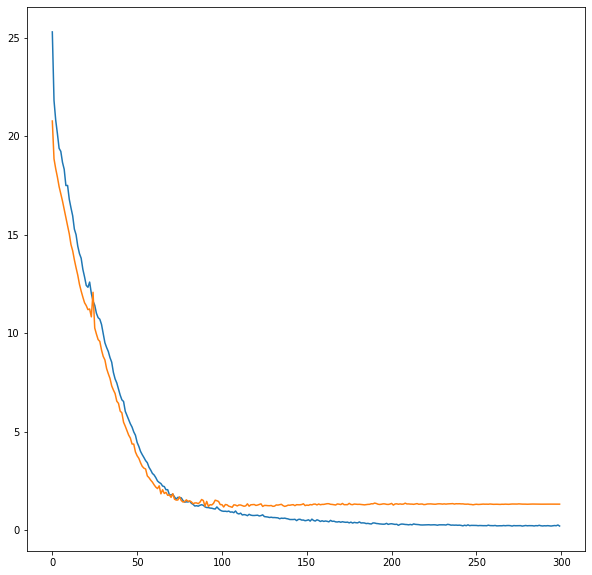

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_record)
plt.plot(val_loss_record)

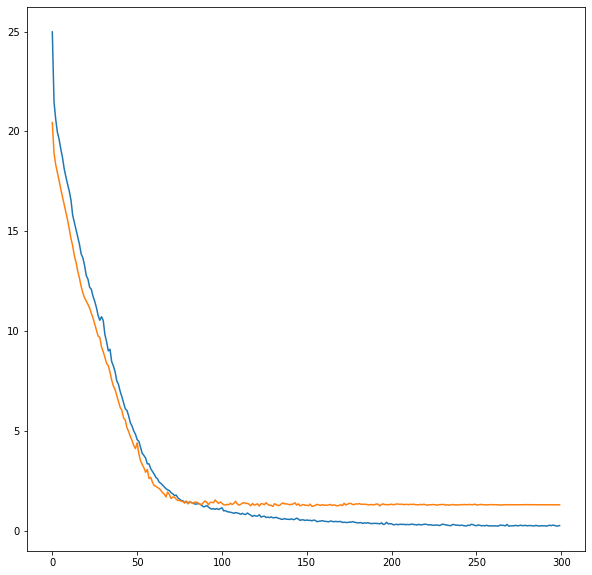

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_record)
plt.plot(val_loss_record)

In [ ]:
checkpoint = torch.load("ResNet50_nopretrain_epoch_300")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>